# Домашняя работа 

В этой работы мы будем учиться предсказывать зарплату data scientist-ов в зависимочти от ряда факторов с помощью градиентоного бустинга

Цель домашней работы научиться предсказывать зарплаты (salary_in_usd) по ряды факторов 

work_year: The number of years of work experience in the field of data science.

experience_level: The level of experience, such as Junior, Senior, or Lead.

employment_type: The type of employment, such as Full-time or Contract.

job_title: The specific job title or role, such as Data Analyst or Data Scientist.

salary: The salary amount for the given job.

salary_currency: The currency in which the salary is denoted.

salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

employee_residence: The country or region where the employee resides.

remote_ratio: The percentage of remote work offered in the job.

company_location: The location of the company or organization.

company_size: The company’s size is categorized as Small, Medium, or Large.

In [256]:
import pandas as pd

In [257]:
df = pd.read_csv("data/ds_salaries.csv")

In [258]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.2 балла)

Разделите выборку на train, val, test (80%, 10%, 10%) в качестве таргета выберите salary_in_usd, удалите из признаков (salary) чтобы избежать лика в данных.

In [259]:
from sklearn.model_selection import train_test_split

In [260]:
df = df.drop(['salary'], axis = 1)
X = df.drop(['salary_in_usd'], axis = 1)
y = df['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.11111, random_state=42)

## Задание 2 (0.3 балла)

Обучите модель линейной регресии и оцените её качество через mape и rmse

In [261]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.preprocessing import OneHotEncoder

In [282]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train)
X_train_one = encoder.transform(X_train)
X_test_one = encoder.transform(X_test)

In [263]:
lr = LinearRegression()
lr.fit(X_train_one, y_train)
y_pred = lr.predict(X_test_one)
print(f'LinReg MAPE: {MAPE(y_test, y_pred)}')
print(f'LinReg RMSE: {RMSE(y_test, y_pred)}')

LinReg MAPE: 0.45939528357046716
LinReg RMSE: 51397.14424934963


## Задание 3 (0.3 балла)

Обучите модель бустинга выберите любую из трех библиотек catboost, xgboost, lightgbm и оцените её качество через mape и rmse

In [264]:
import lightgbm as lgb

In [265]:
gbm = lgb.LGBMRegressor()
gbm.fit(X_train_one, y_train)
y_pred = gbm.predict(X_test_one, num_iteration=gbm.best_iteration_)
print(f'Lightgbm MAPE: {MAPE(y_test, y_pred)}')
print(f'Lightgbm RMSE: {RMSE(y_test, y_pred)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 3379, number of used features: 49
[LightGBM] [Info] Start training from score 137342.943178
Lightgbm MAPE: 0.4104916635994607
Lightgbm RMSE: 50741.39429327837


## Задание 4 (0.6 балла)

Далее предобработайте категориальные признаки с помощью onehot кодирования, labelencoder и счетчиков (mean target encoding) сравните качество трёх моделей бустинга (catboost, xgb, lgbm) с помощью mape и rmse. Какие выводы можно сделать? Выберите для каждой из моделей лучшее кодирование категориальных признаков - в дальнейшем будем работать только с ним.

In [266]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

In [267]:
label_encoder = LabelEncoder()
X_train_label = X_train.copy()
X_test_label = X_test.copy()
for column in X_test_label.columns:
    label_encoder.fit(X_train_label[column])
    X_train_label[column] = label_encoder.transform(X_train_label[column])
    label_encoder_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    X_test_label[column] =X_test_label[column].apply(lambda x: label_encoder_dict.get(x, -1))
target_encoder = TargetEncoder(smoothing=1.0)
target_encoder.fit(X_train, y_train)
X_train_t = target_encoder.transform(X_train)
X_test_t = target_encoder.transform(X_test)

In [268]:
import catboost
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [269]:
cat_model = CatBoostRegressor(iterations=10)
xgb_model = XGBRegressor(seed=42)
gbm_model = lgb.LGBMRegressor(random_state=42)

for X_train_encoded, X_test_encoded, name in zip([X_train_one, X_train_label, X_train_t],
                                                 [X_test_one, X_test_label, X_test_t],
                                                 ['onehot', 'labelencoder', 'mean target encoding']):
    cat_model.fit(X_train_encoded, y_train, verbose=False)
    xgb_model.fit(X_train_encoded, y_train)
    gbm_model.fit(X_train_encoded, y_train)
    
    y_pred_cat = cat_model.predict(X_test_encoded)
    y_pred_xgb = xgb_model.predict(X_test_encoded)
    y_pred_gbm = gbm_model.predict(X_test_encoded)
    
    print(f'Catboost {name} MAPE: {MAPE(y_test, y_pred_cat)}')
    print(f'Catboost {name} RMSE: {RMSE(y_test, y_pred_cat)}')
    print(f'Xgboost {name} MAPE: {MAPE(y_test, y_pred_xgb)}')
    print(f'Xgboost {name} RMSE: {RMSE(y_test, y_pred_xgb)}')
    print(f'LightGBM {name} MAPE: {MAPE(y_test, y_pred_gbm)}')
    print(f'LightGBM {name} RMSE: {RMSE(y_test, y_pred_gbm)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 3379, number of used features: 49
[LightGBM] [Info] Start training from score 137342.943178
Catboost onehot MAPE: 0.46163870875722085
Catboost onehot RMSE: 51089.5902646199
Xgboost onehot MAPE: 0.38533484048284256
Xgboost onehot RMSE: 49586.68669425077
LightGBM onehot MAPE: 0.4104916635994607
LightGBM onehot RMSE: 50741.39429327837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 3379, number of used features: 8


CatBoost показал себя лучше всего с mean target encoding, xgboost - примерно одинаково с onehot encoding и mean target encoding (пусть будет mean), gbm - незначительно лучше с onehot encoding.

## Задание 5 (0.6 балла)

Покажите, где ошибаются ваши модели. Выведите топ 20 примеров с наибольшей ошибкой для каждой модели. Проанализируете их, постарайтесь выделить группы с причинами ошибок в моделе. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [277]:
cat_model.fit(X_train_t, y_train, verbose=False)
y_pred_cat = cat_model.predict(X_test_t)
a_cat = X_test.to_numpy()[np.argsort(np.abs(y_pred_cat-y_test))[-1:-21:-1]]
b_cat = np.sort(np.abs(y_pred_cat-y_test))[-1:-21:-1]
print(pd.DataFrame(np.column_stack((a_cat, b_cat)), columns=np.append(X_test.columns, 'error')))

xgb_model.fit(X_train_t, y_train)
y_pred_xgb= xgb_model.predict(X_test_t)
a_xgb = X_test.to_numpy()[np.argsort(np.abs(y_pred_xgb-y_test))[-1:-21:-1]]
b_xgb = np.sort(np.abs(y_pred_xgb-y_test))[-1:-21:-1]
print(pd.DataFrame(np.column_stack((a_xgb, b_xgb)), columns=np.append(X_test.columns, 'error')))

gbm_model.fit(X_train_one, y_train)
y_pred_gbm= gbm_model.predict(X_test_one)
a_gbm = X_test.to_numpy()[np.argsort(np.abs(y_pred_gbm-y_test))[-1:-21:-1]]
b_gbm = np.sort(np.abs(y_pred_xgb-y_test))[-1:-21:-1]
print(pd.DataFrame(np.column_stack((a_gbm, b_gbm)), columns=np.append(X_test.columns, 'error')))

   work_year experience_level employment_type  \
0       2023               SE              FT   
1       2023               SE              FT   
2       2023               SE              FT   
3       2023               EX              FT   
4       2023               SE              FT   
5       2023               MI              FT   
6       2022               SE              FT   
7       2023               SE              FT   
8       2023               SE              FT   
9       2022               SE              FT   
10      2022               SE              FT   
11      2022               EN              FT   
12      2020               EX              FT   
13      2023               SE              FT   
14      2023               SE              FT   
15      2022               SE              FT   
16      2023               SE              FT   
17      2023               SE              FT   
18      2022               EX              FT   
19      2023        

Самая большая связь прослеживается между большой ошибкой и 2023 годом, USD, M и FT, однако без знания о распространенности этих признаков в таблице эта информация непоказательна.

## Задание 6 (2 балла)

Сравните feature importance трёх моделей с помощью shap. Как выводы можно сделать?

In [271]:
import shap
from catboost import *

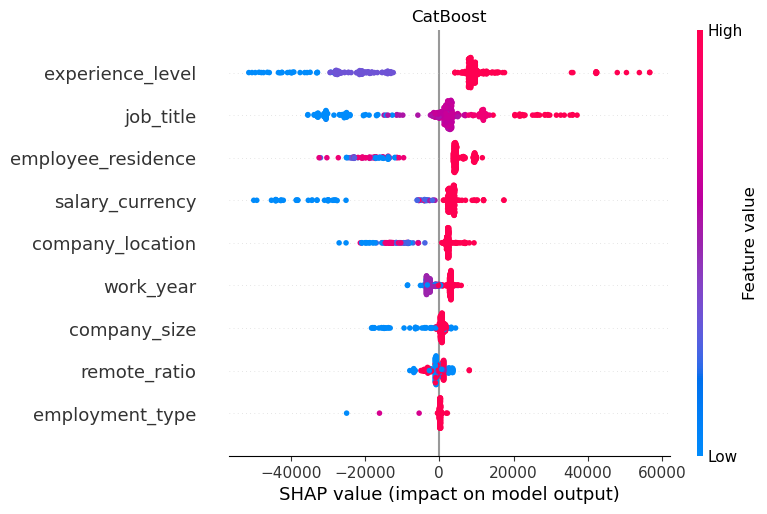

In [272]:
shap_values_cat = cat_model.get_feature_importance(Pool(X_test_t, y_test), type='ShapValues')[:, :-1]
shap.summary_plot(shap_values_cat, X_test_t, max_display=25, auto_size_plot=True, show=False)
plt.title("CatBoost")
plt.show()

Люди с большим опытом работы (здесь и дальше с большим относительно кодировки), более важных должностей и из больших компаний получают большую заработную плату. Заработная плата практически не зависит от remote_ratio.

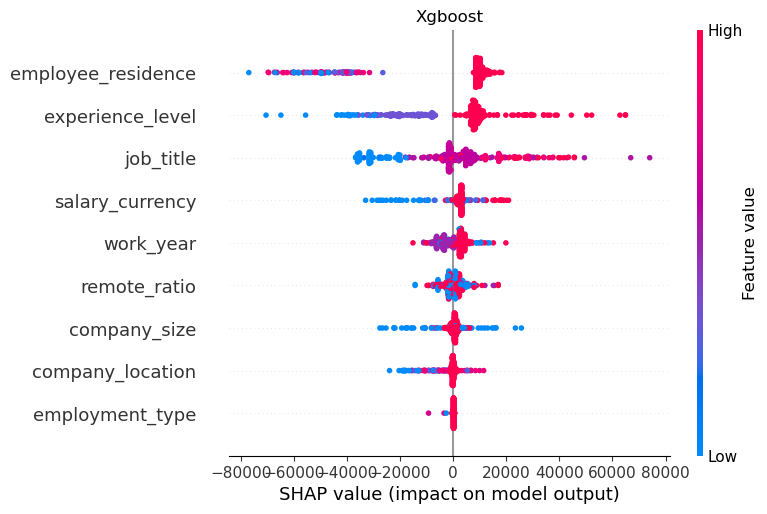

In [278]:
shap_values_xgb = shap.TreeExplainer(xgb_model).shap_values(X_test_t)
shap.summary_plot(shap_values_xgb, X_test_t, max_display=25, auto_size_plot=True, show=False)
plt.title("Xgboost")
plt.show()

Выводы в общем совпадают с предыдущими, но зависимость от названия работы менее четкая.

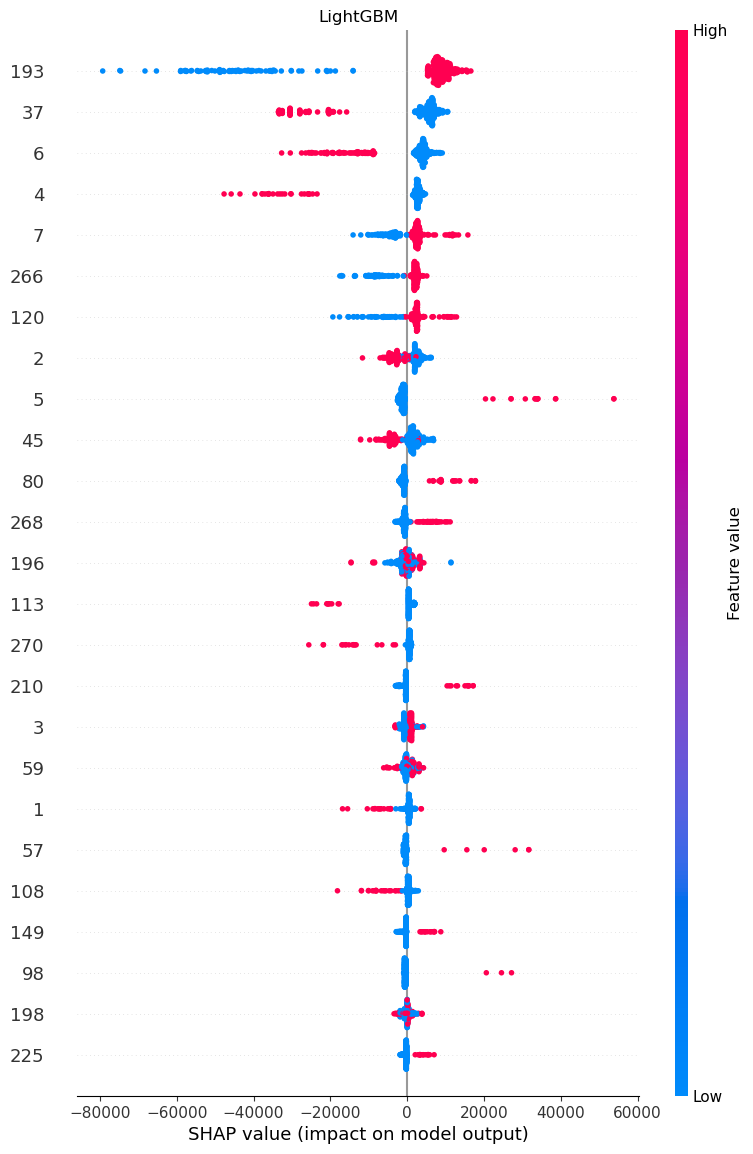

In [291]:
X_new = pd.DataFrame(X_test_one.toarray())
feature_names = (pd.get_dummies(X_test, drop_first = True,dtype = int)).columns
shap_values_gbm = shap.TreeExplainer(gbm_model).shap_values(X_new)
shap.summary_plot(shap_values_gbm, X_new, max_display=25, auto_size_plot=True, show=False)
plt.title("LightGBM")
plt.show()

Признак 193, 7, 266. 120 положительно кореллируют с зарплатой, 37, 6, 4 - отрицательно. 196, 59, 198 - непоказательны.

## Задание 7 (2 балла)
Придумайте признаки для улучшения качества моделей на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво каждой модели? Реализуйте признаки и проверьте улучшилось ли качество моделей. Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы

## Задание 8 (3 балла)
Напишите функцию для оптимизации гиперпараметров трёх моделей бустинга: xgboost, catboost и lightgbm. Функция должна работать максимально эффективно по времени и качеству (соответственно, полный перебор - самый тупой вариант)

В случае Catboost, используйте pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметры cat_features.

Подберите для каждой из моделей лучшие гиперпараметры. 

## Задание 9 (1 балл)

Сделайте выводы про модели бустинга, какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания